In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
df = pd.read_csv("AB_NYC_2019.csv")

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
# Anzahl Nachbarschaften
df['neighbourhood'].nunique()

221

In [5]:
# Anzahl Hosts
df['host_id'].nunique()

37457

## Nachbarschaftsanalyse mit Preis, Koordinaten und zufälliger Farbe

In [6]:
df_nh = df.groupby(['neighbourhood'])[['price', 'latitude', 'longitude']].mean()
df_nh = df_nh.add_prefix('avg_')
df_nh['rgba_color'] = [(np.random.random(),np.random.random(),np.random.random(),np.random.random()) for x in df_nh.index]
df_nh.head()

,avg_price,avg_latitude,avg_longitude,rgba_color
neighbourhood,,,,
Allerton,87.595238,40.865292,-73.858727,"(0.7900617665207339, 0.29177537193563163, 0.49..."
Arden Heights,67.250000,40.552410,-74.182253,"(0.9362642321216815, 0.1460754975444437, 0.877..."
Arrochar,115.000000,40.593900,-74.074600,"(0.6912052338393905, 0.0819004719858909, 0.533..."
Arverne,171.779221,40.591853,-73.794839,"(0.795391153374959, 0.9118224689525681, 0.3057..."
Astoria,117.187778,40.764299,-73.920002,"(0.6225950795236844, 0.03505136157219768, 0.81..."


## Kriminalstatistik

In [7]:
crime = pd.read_csv("https://raw.githubusercontent.com/hka-mmv/dscb230-exercise/main/e1/lecturer/NYPD_Complaint_Map__Year_to_Date.csv")
# Anzahl Verbrechen pro Distrikt
crime.groupby('BORO_NM', as_index=False)[['CMPLNT_NUM']].count().rename(columns={'BORO_NM': 'District', 'CMPLNT_NUM': 'Number of Crimes'})

,District,Number of Crimes
0,BRONX,20778
1,BROOKLYN,27740
2,MANHATTAN,22904
3,QUEENS,21009
4,STATEN ISLAND,4201


In [8]:
#Vorbereitung Plotting

# Parameter für Preis Obergrenze, falls Berechnung zu lange dauert
price_limit = 10000
df_restricted = df.where(df['price']<price_limit).dropna()
df_restricted = df_restricted.join(df_nh, on='neighbourhood')

x = df_restricted['longitude']
y = df_restricted['latitude']
xy_len = len(x)
z_pos = [0]*xy_len
xy_height = [0.001]*xy_len
z_height = df_restricted['price']

nhg_colormap = {'Brooklyn': 'g',
                'Manhattan': 'r',
                'Queens': 'b',
                'Bronx': 'y',
                'Staten Isoland': 'black'}


# Geoanalyse
## per lat-long scatterplot

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

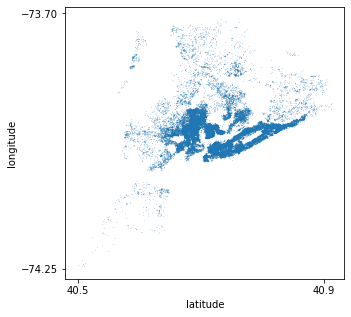

In [9]:
# Scatterplot long-lat

plt.rcParams["figure.figsize"]=5,5

df.plot(x='latitude', y='longitude', kind='scatter', s=0.005, xticks=[40.5,40.9], yticks=[-74.25, -73.7])

### interaktive Heatmap mit folium

In [10]:
# Achtung Rechenintensiv. Bei Bedarf df trimmen
import folium
from folium import plugins


# collect coordinates
coordinates = [[x[1]['latitude'], x[1]['longitude']]for x in df.iterrows()]
# initalize map with mean lat-long 
ny_map = folium.Map(location=[40.728949,-73.952170], zoom_start=11)
# draw heatmap
plugins.HeatMap(coordinates, radius=8, blur=10).add_to(ny_map)
ny_map


### Andere Heatmap-Ansätze

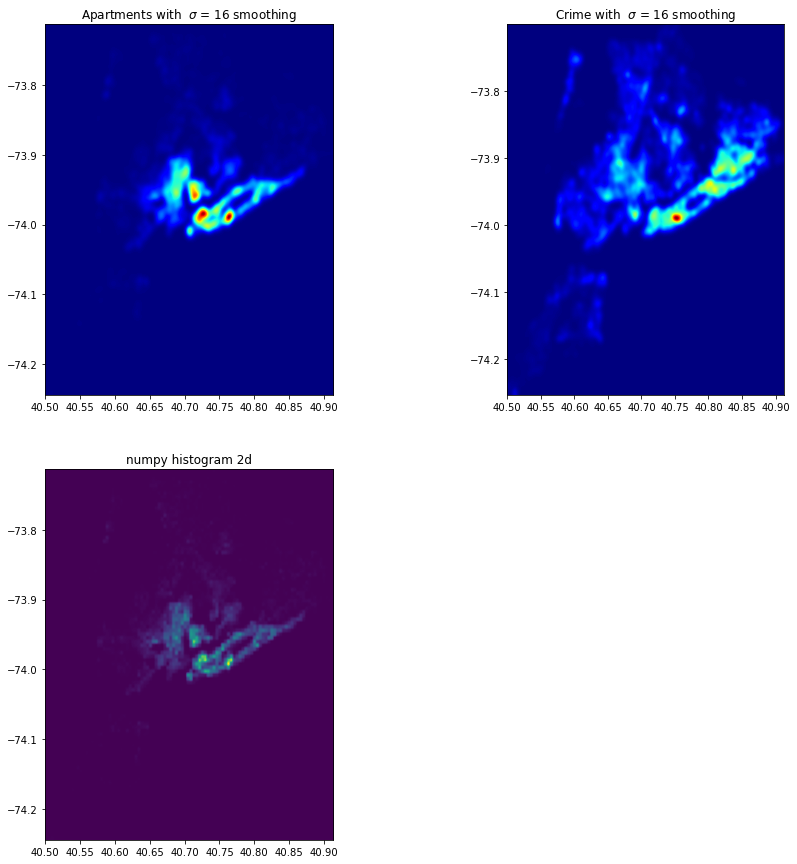

In [11]:
# https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set#2371812
# Heatmap Ansatz Jurgy
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

plt.rcParams["figure.figsize"]=15,15

def create_heatmap(x, y, s, bins=2000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

s = 16
ax11 = plt.subplot(221)
img, extent = create_heatmap(df['latitude'], df['longitude'], s)
ax11.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
ax11.set_title("Apartments with  $\sigma$ = %d smoothing" % s)

ax12 = plt.subplot(222)
img, extent = create_heatmap(crime['Latitude'], crime['Longitude'], s)
ax12.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
ax12.set_title("Crime with  $\sigma$ = %d smoothing" % s)

#Ansatz Ptomato
heatmap, xedges, yedges = np.histogram2d(df['latitude'], df['longitude'], bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

ax2 = plt.subplot(223)
ax2.imshow(heatmap.T, extent=extent, origin='lower')
ax2.set_title("numpy histogram 2d")
plt.show()

# 3D Plots
## x,y entspricht Koordinaten, Höhe enspricht Preis
## Farbe und Alpha zufällig je Nachbarschaft gewählt

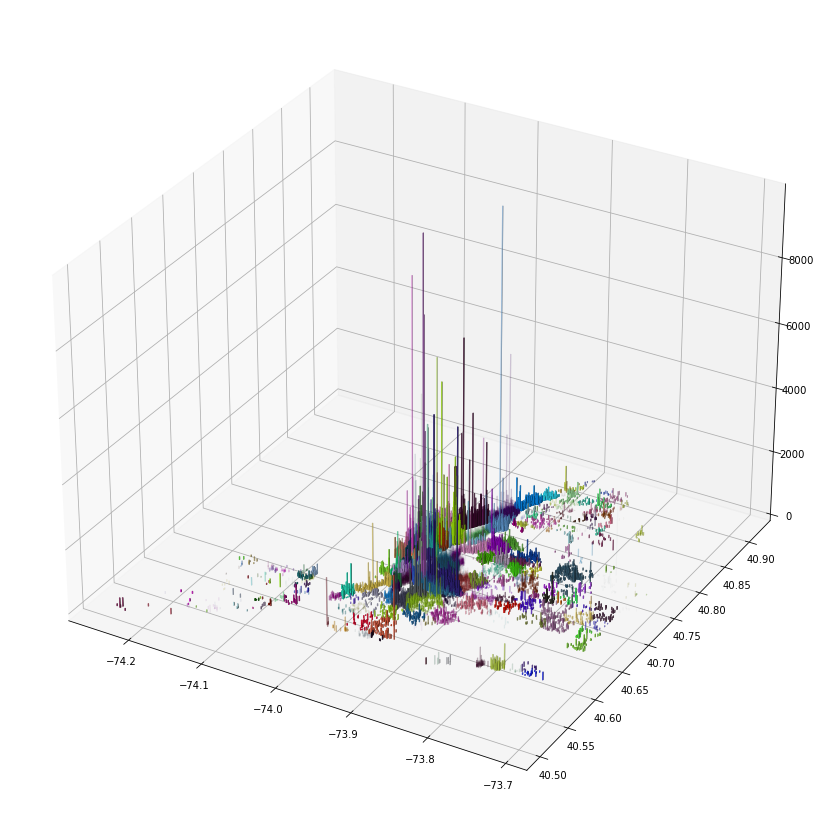

In [12]:
#Position mit Preis als Höhe und Farbe nach Nachbarschaft
plt.rcParams["figure.figsize"]=15,15
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(x,y,z_pos,xy_height,xy_height,z_height,color=df_restricted['rgba_color'])
plt.show()

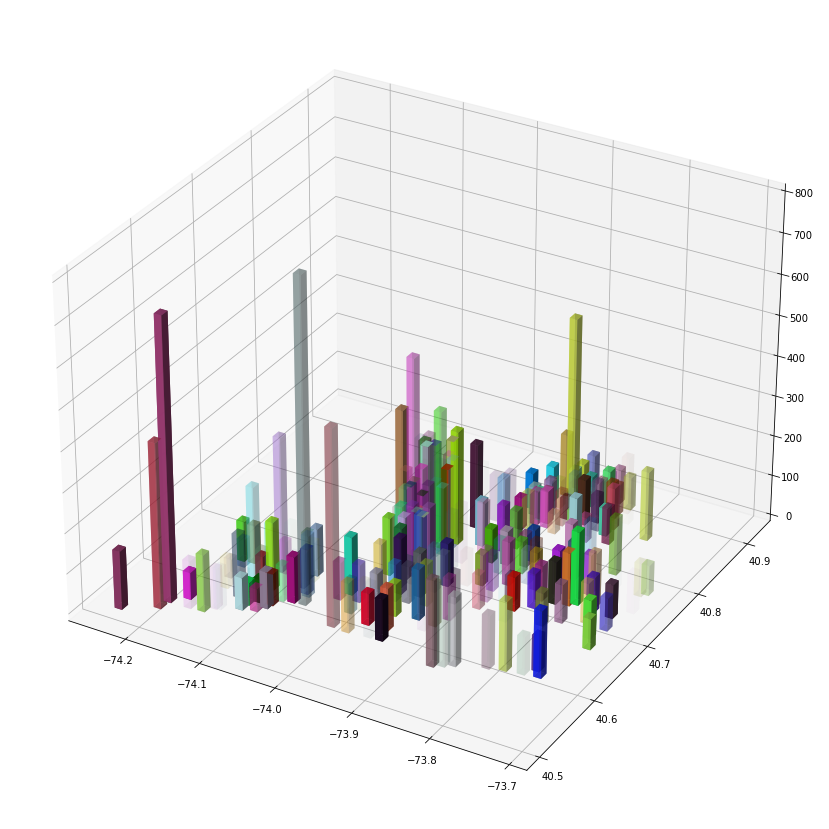

In [13]:
# Nachbarschaften mit Preis als Höhe

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df_nh['avg_longitude']
y = df_nh['avg_latitude']
xy_len = len(x)
z_pos = [0]*xy_len
xy_height = [0.01]*xy_len
z_height = df_nh['avg_price']

ax.bar3d(x,y,z_pos,xy_height,xy_height,z_height,color=df_nh['rgba_color'])

# Korrelationsmatrix als Heatmap


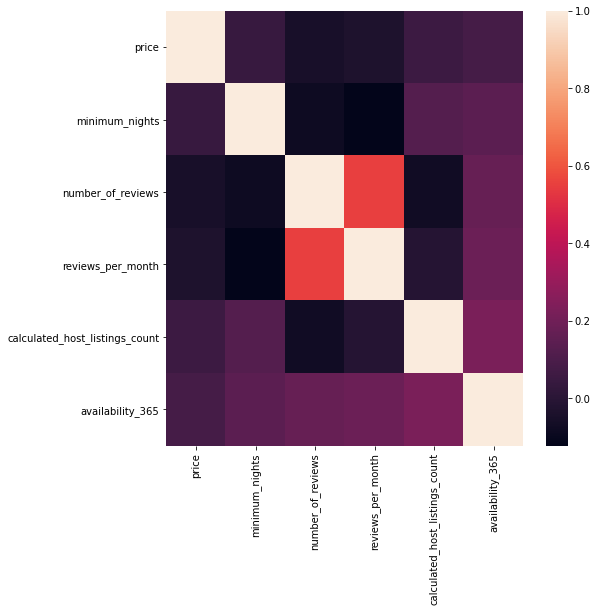

In [14]:
import seaborn as sns
plt.rcParams["figure.figsize"]=8,8
sns.heatmap(df.drop(['id', 'host_id', 'longitude', 'latitude'], axis=1).corr())
plt.show()

# Wordcloud aus Apartment Namen


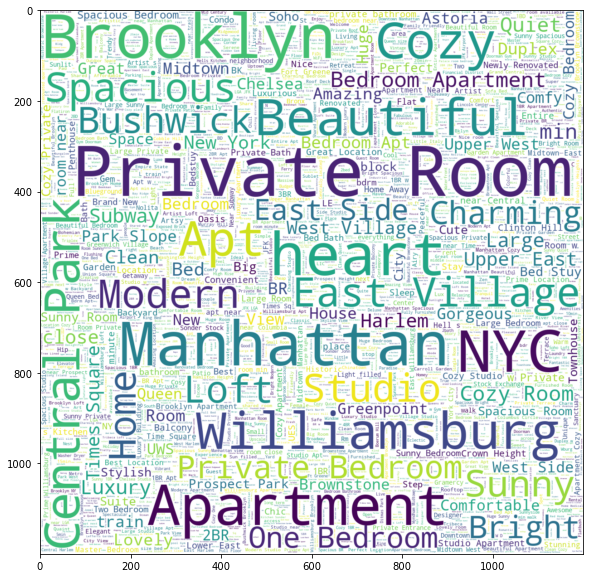

In [15]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

corpus = word_tokenize(' '.join(df['name'].astype(str)))
wc = WordCloud(background_color='white', random_state=1, max_words=3000, width=1200, height=1200)
wc.generate(' '.join(corpus))

plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation="bilinear")
plt.show()